In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
class Experiment:
    def __init__(self, parameters_file):
        self.parameters_file = parameters_file
        self.parameters=[]
        self.list_function_id=[]
        self.list_name=[]
        self.list_range_low=[]
        self.list_range_high=[]
        self.list_dimensions_vector=[]
        self.readParameters()
        self.solution_file = 'solutions.csv'
        self.solution_df = None
        
    def readParameters(self):
        with open(self.parameters_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.parameters.append(row)
        
        #decode the parameters
        for i in range(1,len(self.parameters)):
            self.list_function_id.append(self.parameters[i][0]) #function_id
            self.list_name.append(self.parameters[i][1]) # function name
            self.list_range_low.append(self.parameters[i][2]) # range low
            self.list_range_high.append(self.parameters[i][3]) # range high
            self.list_dimensions_vector.append(self.parameters[i][4:]) # dimension vector, from 4 to the last element
            
    def delete_all_output_files(self):
        files = glob.glob('f*.csv')
        for f in files:
            os.remove(f)
            
    def merge_all_output_files(self):
        files = glob.glob("./f*.csv")
        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv('solutions.csv',index_col=False)
        df.sort_values(by=['dimensions', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('dimensions'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='dimension: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend()
        plt.grid()
        plt.title('Running time')
        
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, ax = plt.subplots(figsize=(8,4))
            plt.errorbar(data['dimensions'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            plt.plot(data['dimensions'],data['median'],label='median')
            plt.fill_between(data['dimensions'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            plt.xticks(data['dimensions'])
            plt.title("f%d : %s"%(id,test.list_name[id-1]))
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('dimensions')
            plt.ylabel('solution')
            plt.grid()
        

    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        process_list = []
        for i in range(len(self.list_function_id)): # run each function
            for dimension in self.list_dimensions_vector[i]: # run different dimensions of each function
                #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                process = subprocess.Popen([
                                "../bin/debug/project.exe"
                                #"../bin/release/project.o"
                                ,str(1) # optimization algorithm id
                                ,"../config/optimization_alg_conf/ga_config.csv"  # optimization configuration file
                                ,"f"+self.list_function_id[i]+".csv" # optimization result output file
                                ,str(n_runs) # number of runs            
                                ,self.list_function_id[i] #function_id 
                                ,str(dimension)
                                ,self.list_range_low[i]
                                ,self.list_range_high[i]
                               ])
                process_list.append(process)
        
        # wait every process to finish
        for p in process_list:
            p.wait()
        print("----finished----")
        
        self.merge_all_output_files()
        #delete all temp files
        self.delete_all_output_files()

In [7]:
test = Experiment('../config/experiments.txt') 

In [8]:
test.run(50) # n runs

----finished----


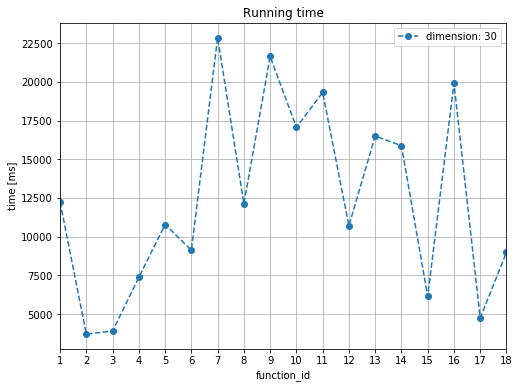

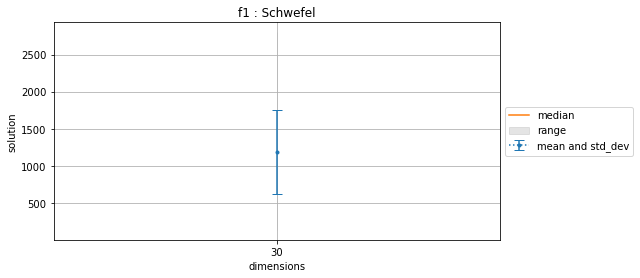

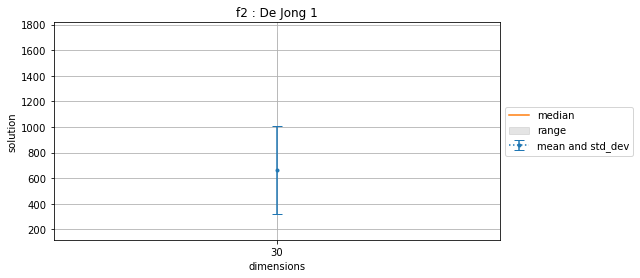

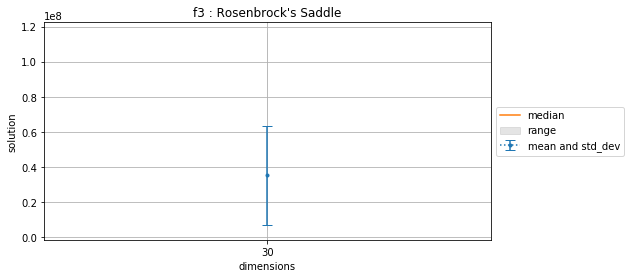

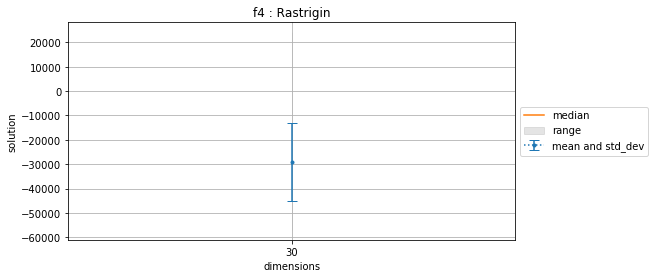

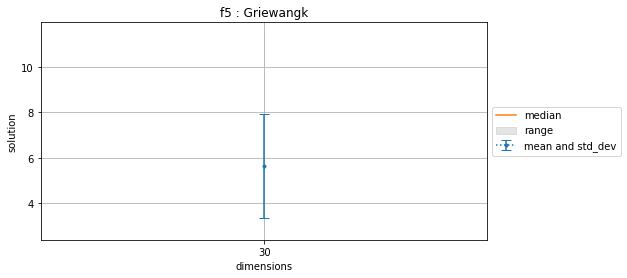

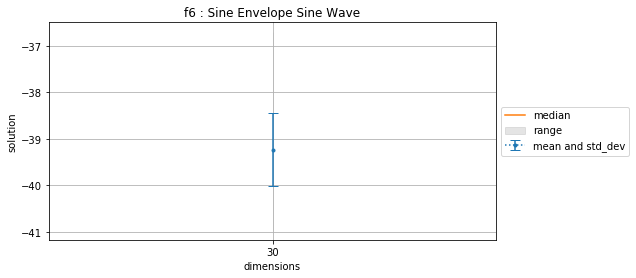

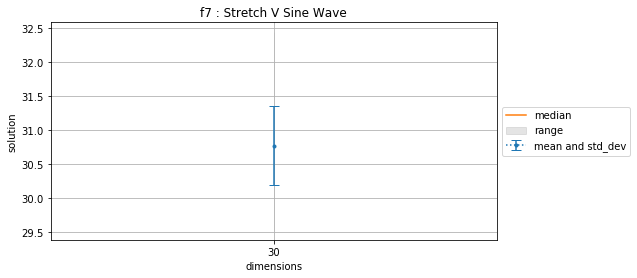

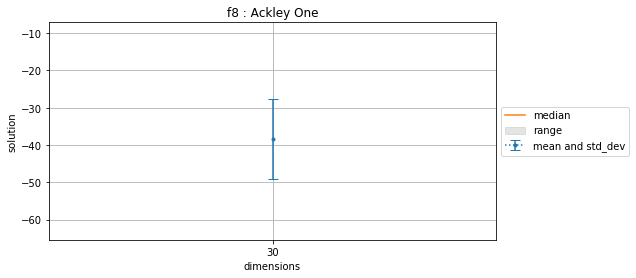

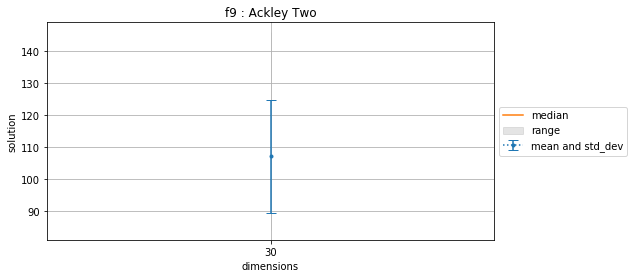

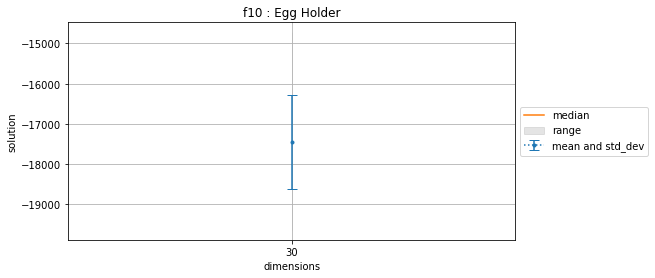

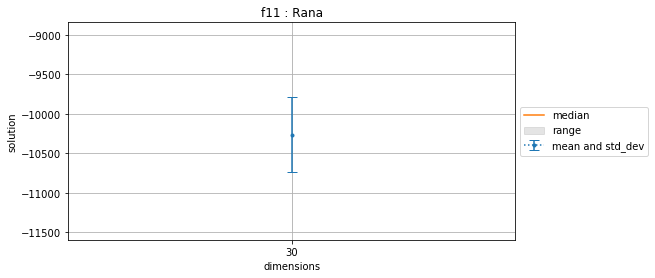

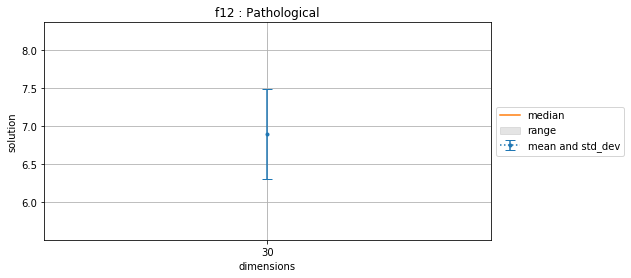

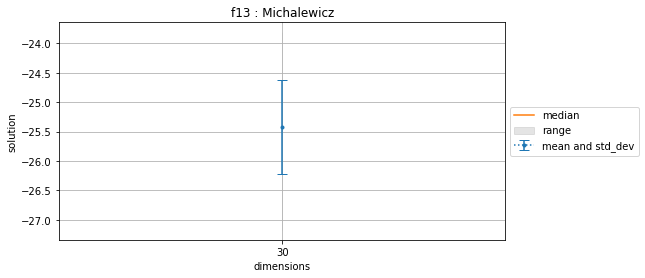

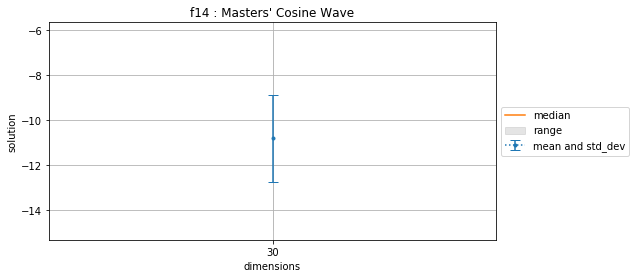

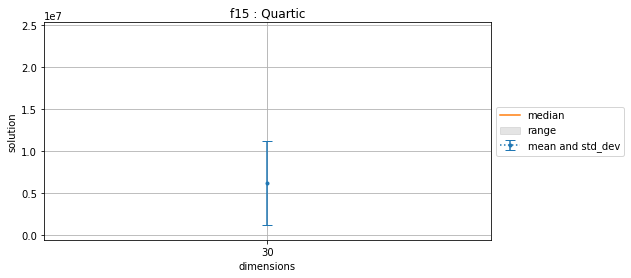

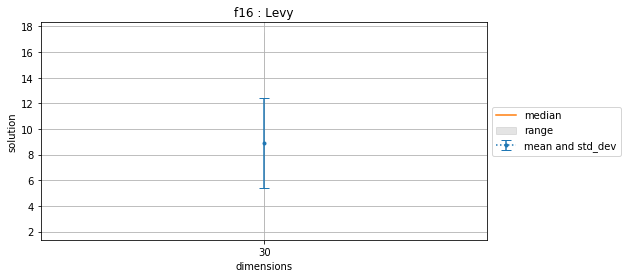

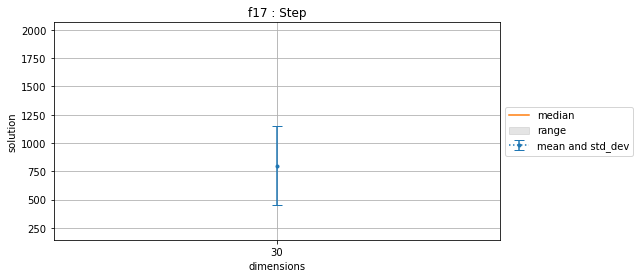

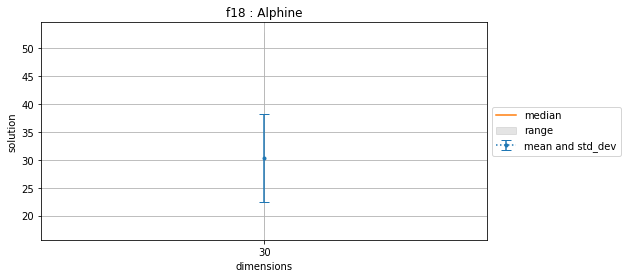

In [9]:
test.plot()

In [10]:
test.solution_df

,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
9,1,50,30,-512,512.00000,1.184450e+03,5.625610e+02,2.661590e+03,1.109180e+03,12237,1.381490e+02,2.799740e+03
10,2,50,30,-100,100.00000,6.637600e+02,3.408420e+02,1.545090e+03,5.919030e+02,3706,1.949910e+02,1.740090e+03
11,3,50,30,-100,100.00000,3.533440e+07,2.822340e+07,1.127140e+08,3.049670e+07,3900,4.029400e+06,1.167440e+08
12,4,50,30,-30,30.00000,-2.906240e+04,1.592630e+04,8.112480e+04,-3.015960e+04,7377,-5.696860e+04,2.415620e+04
13,5,50,30,-500,500.00000,5.647780e+00,2.294850e+00,8.736520e+00,5.125830e+00,10788,2.808010e+00,1.154450e+01
14,6,50,30,-30,30.00000,-3.923220e+01,7.825520e-01,4.242560e+00,-3.936290e+01,9124,-4.095390e+01,-3.671140e+01
15,7,50,30,-30,30.00000,3.076930e+01,5.838670e-01,2.909950e+00,3.077880e+01,22872,2.953050e+01,3.244040e+01
16,8,50,30,-32,32.00000,-3.835830e+01,1.078250e+01,5.302780e+01,-4.023580e+01,12129,-6.276640e+01,-9.738600e+00
17,9,50,30,-32,32.00000,1.071660e+02,1.768600e+01,6.190810e+01,1.031500e+02,21655,8.403130e+01,1.459390e+02
0,10,50,30,-500,500.00000,-1.745300e+04,1.161260e+03,4.917290e+03,-1.744440e+04,17068,-1.963740e+04,-1.472010e+04
